<h1 align=center><font size = 7 color=#993399>Assignment</font></h1> 
<h2 align=center><font size = 6 color=#993399>Segmenting and Clustering Neighborhoods in Toronto</font></h2>  

## Introduction
 we will explore and cluster the neighborhoods in Toronto.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#item1">Answer 1</a></li>
        <li><a href="#item2">Answer 2</a></li>
        <li><a href="#item3">Answer 3</a></li>
    </ol>
</div>
<br>
<hr>

# SECTION 1 <a id='#item1'></a>

## 1. Create a notebook
__Start by creating a new Notebook for this assignment.__

<font color=blue>*>>This notebook is created and uploaded to Github.*</font>

## 2. Scrape the web to obtain data
__Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below: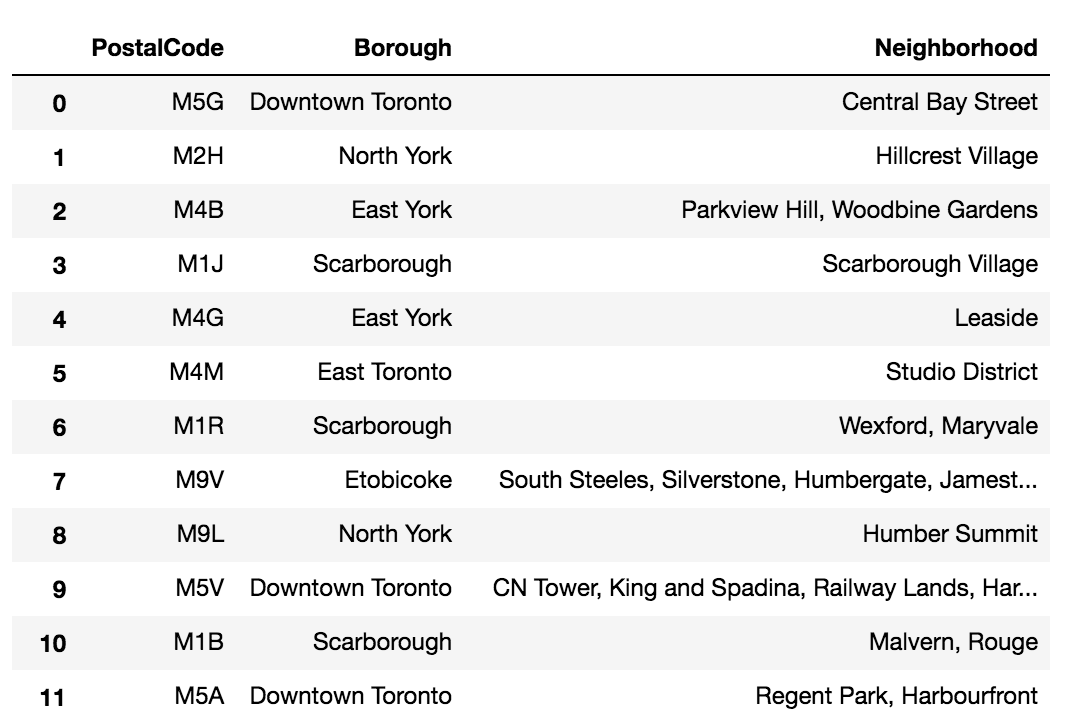__

<font color=blue>*>>Import all required libraries.*</font>

In [1]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
from geopy.geocoders import Nominatim
import geocoder
import time
import re
import folium
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
import json # library to handle JSON files
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = urllib.request.urlopen(url) # connect to website

# Check if Page is getting connected
try:
    page = urllib.request.urlopen(url)
    print("Page loaded successfully.")
except:
    print("An error occured.")
    
soup = BeautifulSoup(page, 'lxml')# to parse the html page
print(str(soup)[0:350]) #check page [only printing part of it]

Page loaded successfully.
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of postal codes of Canada: M - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["


we can see the html page is loaded correctly.
Now we get the table part. it is saved as class 'wikitable'

In [3]:
tabledata = soup.find(class_='wikitable')# get 'wikitable'
print(str(tabledata)[0:158])# check to see the table data (only first few characters)

<table class="wikitable">
<tbody><tr>
<th>Postal code
</th>
<th>Borough
</th>
<th>Neighborhood
</th></tr>
<tr>
<td>M1A
</td>
<td>Not assigned
</td>
<td>
</td>


The table is encoded as:
* Each row is between " 'tr' row1 '/tr' "
* Each cell in row is between " 'td' cell 'td' "
* The header cells are between " 'th' header cell '/th' "
We seperate it save it as a list of lists.

In [4]:
tableList = [[celldata.text.rstrip() for celldata in rowdata.find_all(["th","td"])]
                        for rowdata in tabledata.find_all("tr")]
tableList[0:10] # print the first 10 rows to check

[['Postal code', 'Borough', 'Neighborhood'],
 ['M1A', 'Not assigned', ''],
 ['M2A', 'Not assigned', ''],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Regent Park / Harbourfront'],
 ['M6A', 'North York', 'Lawrence Manor / Lawrence Heights'],
 ['M7A', 'Downtown Toronto', "Queen's Park / Ontario Provincial Government"],
 ['M8A', 'Not assigned', ''],
 ['M9A', 'Etobicoke', 'Islington Avenue']]

The First Row is the header, the rest rows are data.

## 3. DataFrame Creation
To create the above dataframe:
* __The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood__

In [5]:
postal_df=pd.DataFrame(tableList[1:],columns =tableList[0])
postal_df.head() # to see the first few rows of dataframe

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


* __Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.__

In [6]:
postal_df=postal_df[postal_df['Borough'] != 'Not assigned']#Ignore cells with a borough that is Not assigned.
postal_df.shape

(103, 3)

* __More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.__

In [7]:
#Check to see if the unique groups are same as orginal table
postal_df.groupby('Postal code').count().shape

(103, 2)

Since the number of rows of groupby 'Postal code' and original table are same. we can conclude there are no duplictaes in 'Postal code' column.  However multiple neighborhood in the column are seperated by '/' inst

In [8]:
postal_df['Neighborhood']=postal_df['Neighborhood'].str.replace(' /',",")

* __If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.__

In [9]:
postal_df[(postal_df['Neighborhood'] == '') | (postal_df['Neighborhood']=='Not assigned')].shape

(0, 3)

Since number of rows is 0 there are no empty cells in neighborhood column

* __Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.__

In [10]:
# done

* __In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.__

In [11]:
print('Shape of dataframe is', postal_df.shape)

Shape of dataframe is (103, 3)


## 4. Link to Github
Submit a link to your Notebook on your Github repository.  
  
<font color=blue>*>>This notebook is created and uploaded to Github.*</font>

# SECTION 2 <a id='#item2'></a>

## 5. Create location dataframe
Use the Geocoder package or the csv file to create the following dataframe:

we can use geopy package to get the coordinates

In [12]:
locator=Nominatim(user_agent='myleGeocoder')
def get_coordinates(row):
    m = re.search("(^.*?)(?=,)", row['Neighborhood'])    
    if m is not None:
        row['Neighborhood']=m.group(0)
    # initialize your variable to None
    lat_lng_coords = None
    location = None
    count=0;
    # loop until you get the coordinates
    while((location is None) or count < 4):
        print(count)
        try:
            #g = geocoder.google('{}, {}, {}'.format(row['Postal code'],row['Neighborhood'],row['Borough']))
            #lat_lng_coords = g.latlng
            if count < 2:
                location = locator.geocode('{}, {}, {}, Canada'.format(row['Postal code'],row['Neighborhood'],row['Borough']))
            elif count < 4:
                location = locator.geocode('{}, {}, Canada'.format(row['Neighborhood'],row['Borough']))
                print(('{}, {}, Canada'.format(row['Neighborhood'],row['Borough'])))
            else:
                location = locator.geocode('{}, Canada'.format(row['Borough']))
                print(('{}, {}, Canada'.format(row['Neighborhood'],row['Borough'])))  
        except:
            pass
        count+=1
        time.sleep(1.5)
    if location is None:
        lat_lng_coords=[None,None]
    else:
        lat_lng_coords=[location.latitude ,location.longitude]
    print(row['Postal code'],count,' = ',lat_lng_coords)
    return lat_lng_coords
#uncomment below code for executing this
#postal_df[['Latitude','Longitude']]=postal_df.apply(get_coordinates,axis=1,result_type='expand' )

The above code can get coordinates , but it takes a long time and is not very reliable, so we are getting it from file stored.

In [13]:
latlong_df= pd.read_csv('Geospatial_Coordinates.csv')
latlong_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
latlong_df.rename(columns={'Postal Code':'Postal code'},inplace=True)
postal_df=pd.merge(postal_df,latlong_df,on='Postal code')
postal_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [15]:
postal_tor_df=postal_df[postal_df['Borough'].str.contains('Toronto')].reset_index(drop=True)
postal_tor_df

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


Now we have fot the Neighborhoods in Toronto along with coordinates

# SECTION 3 <a id='#item43'></a>

## Replace analysis done in New York city data
We generate a map of Totonto with all neighborhoods.

In [16]:
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [17]:
map_canada = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(postal_tor_df['Latitude'], postal_tor_df['Longitude'], postal_tor_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_canada)  
    
map_canada

__Define Foursquare Credentials and Version__

In [18]:
CLIENT_ID = 'GF2DLNI5QSHZTH0MVEI4NCUUFIOEDY2KAKXQFRKOUSAOIQGT' # your Foursquare ID
CLIENT_SECRET = 'CMESPRUX2ANGP0LCSTQREELO1CM042WNK5MTKPMSMIDBR42Z' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Get all the neighborhoods in Tooronto

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
toronto_venues = getNearbyVenues(names=postal_tor_df['Neighborhood'],
                                   latitudes=postal_tor_df['Latitude'],
                                   longitudes=postal_tor_df['Longitude']
                                  )


Analyze Each Neighborhood

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

First, let's write a function to sort the venues in descending order.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Italian Restaurant,Restaurant,Cheese Shop,Seafood Restaurant,Beer Bar,Cocktail Bar,Bakery,Café
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Yoga Studio,Bakery,Performing Arts Venue,Pet Store,Convenience Store,Climbing Gym,Restaurant
2,Business reply mail Processing CentrE,Yoga Studio,Spa,Garden Center,Garden,Gym / Fitness Center,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Bar,Plane,Boutique,Airport,Airport Food Court,Airport Gate,Boat or Ferry
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Burger Joint,Spa,Ice Cream Shop,Gym / Fitness Center,Japanese Restaurant


## we will cluster Neighborhoods as per venues to compare

In [25]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = postal_tor_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # to check the last columns!

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Mexican Restaurant,Café,Theater,Spa,Ice Cream Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Diner,Yoga Studio,College Cafeteria,Beer Bar,Boutique,Sandwich Place,Burger Joint,Burrito Place,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Café,Bubble Tea Shop,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Restaurant,Diner
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Beer Bar,Restaurant,Hotel,American Restaurant,Italian Restaurant,Park,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Women's Store,Cupcake Shop,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


 __Visualize the resulting cluster__

In [27]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## We can see that most neighborhoods in Toronto are similar
# _Thank you !_